# Results Analysis

In [1]:
%matplotlib inline
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import numpy as np
import os
import time
from datetime import timedelta

### Load dataset

In [2]:
# read from csv
input_file_name = "results_id14061721.csv"
input_file_path = os.path.join(os.path.join(os.getcwd(), "data"), input_file_name)
test =  pd.read_csv(input_file_path, index_col=[0,1])

print test.loc[20].shape[0]
test.loc[20].tail()

27856


,true,last value,previous day,previous week,offline,batch
values,,,,,,
2015-02-01 02:45:00,4,5,5,4,4.338341,6.295617
2015-02-01 03:00:00,5,5,5,4,4.360159,6.211736
2015-02-01 03:15:00,5,5,5,3,4.452371,6.215017
2015-02-01 03:30:00,4,5,5,4,4.286409,6.248906
2015-02-01 03:45:00,4,5,5,4,4.278841,6.176314


In [3]:
# read from csv
input_file_name = "id14061721_20_AR_WF_DT.csv"
input_file_path = os.path.join(os.path.join(os.getcwd(), "data", "online results", "RF100-5"), input_file_name)
a =  pd.read_csv(input_file_path, sep=';')

a.shape

(105135, 2)

The problem is that we have different sizes of datasets. Online reuslts are larger, becasue it starts to validate at the first record, while offline and batch are only evaluating the last 20%.

In [4]:
a.tail()

,target,prediction
105130,4,4.803441
105131,5,4.758799
105132,5,4.701248
105133,4,4.751947
105134,4,4.701458


But the tail should be the same. Checking if target is actually the same.

We should take the last chunk of the online data, the same size as offline and batch.

In [5]:
testing_set_point = test.loc[20].shape[0]
main_subset = test.loc[20]
subset = a[-testing_set_point:]

The sizes are now the same.

In [6]:
print test.loc[20].shape
print main_subset.shape
print subset.shape

(27856, 6)
(27856, 6)
(27856, 2)


The problem is that they still have different indexes.

In [7]:
main_subset.tail()

,true,last value,previous day,previous week,offline,batch
values,,,,,,
2015-02-01 02:45:00,4,5,5,4,4.338341,6.295617
2015-02-01 03:00:00,5,5,5,4,4.360159,6.211736
2015-02-01 03:15:00,5,5,5,3,4.452371,6.215017
2015-02-01 03:30:00,4,5,5,4,4.286409,6.248906
2015-02-01 03:45:00,4,5,5,4,4.278841,6.176314


In [8]:
subset.tail()

,target,prediction
105130,4,4.803441
105131,5,4.758799
105132,5,4.701248
105133,4,4.751947
105134,4,4.701458


We will just override index from the main dataframe, to the online subset dataframe.

In [9]:
subset.index = main_subset.index
subset.tail()

,target,prediction
values,,
2015-02-01 02:45:00,4,4.803441
2015-02-01 03:00:00,5,4.758799
2015-02-01 03:15:00,5,4.701248
2015-02-01 03:30:00,4,4.751947
2015-02-01 03:45:00,4,4.701458


Now we can marge.

In [10]:
#pd.concat([main_subset, subset], axis=1) # to check if target and true are the same (they are)
main_subset['online'] = subset['prediction']
main_subset.tail()

,true,last value,previous day,previous week,offline,batch,online
values,,,,,,,
2015-02-01 02:45:00,4,5,5,4,4.338341,6.295617,4.803441
2015-02-01 03:00:00,5,5,5,4,4.360159,6.211736,4.758799
2015-02-01 03:15:00,5,5,5,3,4.452371,6.215017,4.701248
2015-02-01 03:30:00,4,5,5,4,4.286409,6.248906,4.751947
2015-02-01 03:45:00,4,5,5,4,4.278841,6.176314,4.701458


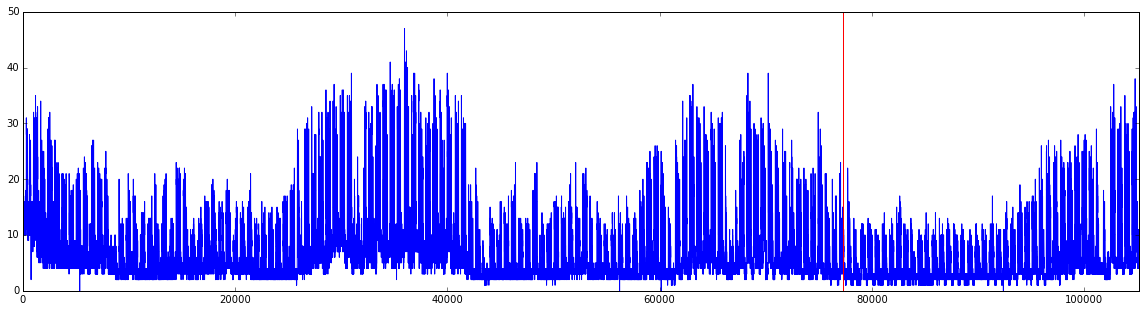

In [11]:
f = a['target'].plot(figsize=(20,5))
f.axvline(len(a)-testing_set_point, color='r')

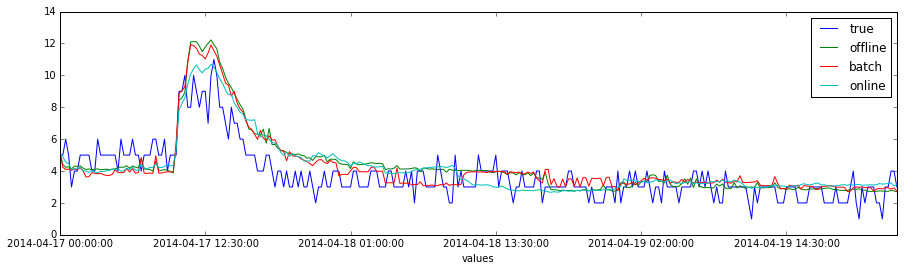

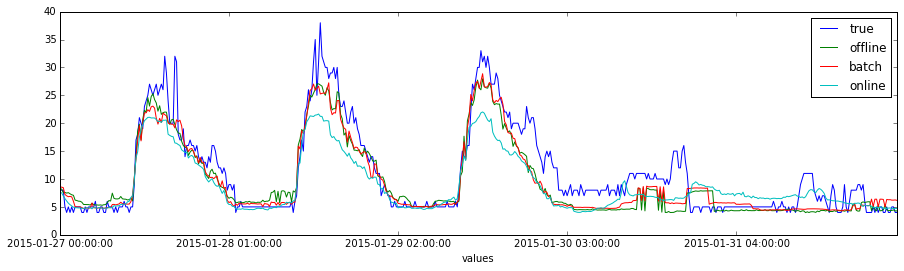

In [12]:
main_subset['2014-04-17 00:00:00':'2014-04-20 00:00:00'][['true','offline','batch', 'online']].plot(figsize=(15,4))
main_subset['2015-01-27 00:00:00':'2015-02-01 23:59:00'][['true','offline','batch', 'online']].plot(figsize=(15,4))

In [96]:
from sklearn.metrics import r2_score

def r2( g ):
    r2_lv = r2_score( g['true'], g['last value'] )
    r2_pd = r2_score( g['true'], g['previous day'] )
    r2_pw = r2_score( g['true'], g['previous week'] )
    r2_offline = r2_score( g['true'], g['offline'] )
    r2_batch = r2_score( g['true'], g['batch'] )
    r2_online = r2_score( g['true'], g['online'] )
    return pd.Series( dict(  r2_lv=r2_lv, r2_pd=r2_pd, r2_pw=r2_pw, r2_offline=r2_offline, r2_batch=r2_batch, r2_online=r2_online ) )

#subset = test['2014-04-17 00:00:00':'2014-04-27 00:00:00']
#subset = test.loc[20]['2015-01-05 00:00:00':'2015-02-01 23:59:00']
#subset = test['2014-04-17 00:00:00':'2015-02-01 23:59:00']
a=main_subset.groupby(main_subset.index.to_datetime().dayofyear, sort=False).apply(r2)
a

,r2_batch,r2_lv,r2_offline,r2_online,r2_pd,r2_pw
107,0.261408,-1.543372,0.189012,0.425454,-0.558841,0.012734
108,-0.285859,-14.673469,-0.680818,-0.704068,-14.508485,-1.433512
109,-0.299210,-1.458360,-0.128366,-0.277574,-1.313751,-0.384119
110,-12.714878,-1.016807,-17.175098,-14.036699,-0.322129,-86.798319
111,0.040191,-0.771656,0.254927,0.477253,-0.768056,0.724416
112,0.860497,-1.106318,0.880059,0.757026,0.507788,0.716323
113,0.774091,-1.887227,0.799716,0.862140,0.656202,0.717271
114,-2.253488,-6.369754,-2.457381,-2.430548,-4.841255,-1.886534
115,-1.470103,-10.269231,-2.244110,-3.775982,-12.807692,-5.500000
116,-1.632354,-1.037410,-2.133836,-0.172773,-0.588489,-2.349640


Bar plot for last month. Major improvement for batch and online is not visible.

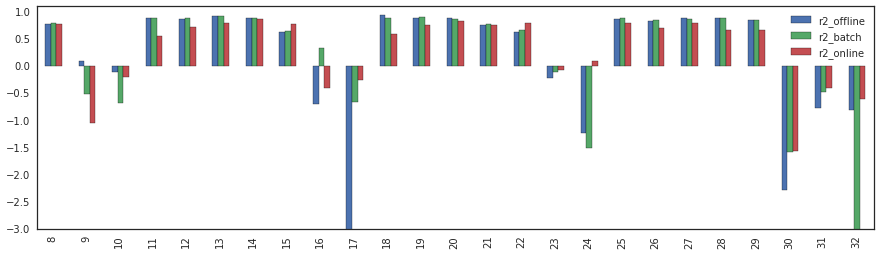

In [97]:
a[['r2_offline','r2_batch', 'r2_online']].tail(25).plot( kind='bar', figsize=(15,4), ylim=(-3, 1.1))

This can also be seen from the distribution plot

In [98]:
#subset = test.loc[20]['2014-04-17 00:00:00':'2015-02-01 23:59:00']
#main_subset['2014-04-17 00:00:00':'2015-02-01 23:59:00']
#a=subset.groupby(subset.index.to_datetime().dayofyear, sort=False).apply(r2)

b = a[['r2_offline','r2_batch', 'r2_online']]
#a[['r2_offline','r2_batch']].plot( kind='hist', figsize=(15,4))
#a[['r2_offline','r2_batch']].hist(figsize=(15,4), bins=20)
#a[['r2_offline','r2_batch']].plot.hist(bins=30)
b[b > 0].plot.hist(bins=30, alpha=0.6)

AttributeError: 'function' object has no attribute 'hist'

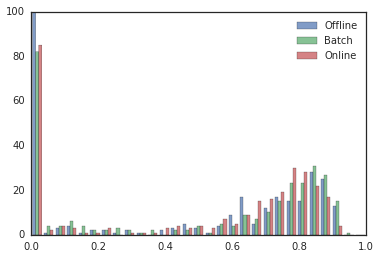

In [99]:
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use('seaborn-deep')

b = a[['r2_offline','r2_batch', 'r2_online']]

c = b[b > 0].reset_index()[['r2_offline','r2_batch', 'r2_online']]

c = c.fillna(0)

x = c["r2_offline"].values
y = c["r2_batch"].values
z = c["r2_online"].values
data = np.vstack([x, y, z]).T
bins = np.linspace(0, 1, 30)

plt.hist(data, bins, alpha=0.7, label=['Offline', 'Batch', 'Online'])
plt.legend(loc='upper right')
plt.show()

R2 scatter plot

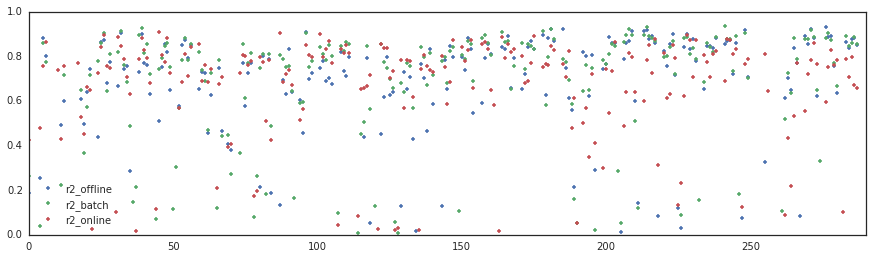

In [100]:
a=main_subset.groupby(main_subset.index.to_datetime().dayofyear, sort=False).apply(r2)

b = a[['r2_offline','r2_batch', 'r2_online']]

#a[['r2_offline','r2_batch']].plot( figsize=(15,4), marker='*')
b[b > 0].reset_index()[['r2_offline','r2_batch', 'r2_online']].plot( figsize=(15,4), marker='.', linestyle='')

Scatter plot for entire testing dataset with regression plot trend, showing that Batch is better. Unfortunatelly the trend is downword. Maybe try with different sensor.

In [101]:
a.shape

(291, 6)

In [102]:
b.head()

,r2_offline,r2_batch,r2_online
107,0.189012,0.261408,0.425454
108,-0.680818,-0.285859,-0.704068
109,-0.128366,-0.299210,-0.277574
110,-17.175098,-12.714878,-14.036699
111,0.254927,0.040191,0.477253


In [103]:
c.head()

,r2_offline,r2_batch,r2_online
0,0.189012,0.261408,0.425454
1,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000
4,0.254927,0.040191,0.477253


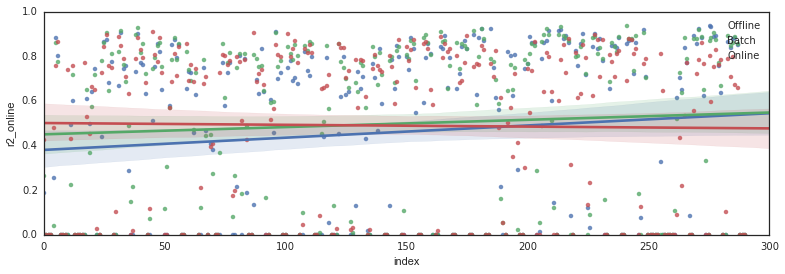

In [104]:
import seaborn as sns

sns.set_style("white")

a=main_subset.groupby(main_subset.index.to_datetime().dayofyear, sort=False).apply(r2)

#tmp = main_subset.loc['2014-04-17 00:00:00':'2015-02-01 23:59:00']
#a=tmp.groupby(tmp.index.to_datetime().dayofyear, sort=False).apply(r2)

b = a[['r2_offline','r2_batch', 'r2_online']]

#c = b.reset_index()[['r2_offline','r2_batch']]
c = b[b > 0].reset_index()[['r2_offline','r2_batch', 'r2_online']]
c = c.fillna(0)
c['index'] = c.index

plt.figure(figsize=(13,4))
#sns.pairplot(c, size=5, aspect=.8, kind="reg");
g = sns.regplot(y="r2_offline", x="index", data=c, label='Offline');
g.set(xlim=(0,300), ylim=(0,1))
sns.regplot(y="r2_batch", x="index", data=c, label='Batch');
sns.regplot(y="r2_online", x="index", data=c, label='Online');

plt.legend(loc='upper right')
plt.show()

In [105]:
import scipy

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=g.get_lines()[0].get_xdata(),y=g.get_lines()[0].get_ydata())
print "Offline slope:", slope

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=g.get_lines()[1].get_xdata(),y=g.get_lines()[1].get_ydata())
print "Batch slope:", slope

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=g.get_lines()[2].get_xdata(),y=g.get_lines()[2].get_ydata())
print "Online slope:", slope

Offline slope: 0.000547574044946
Batch slope: 0.000325398585617
Online slope: -8.00059340599e-05


## MAPE analysis

In [106]:
import regression_metrics as additional_metrics

def mape(g):
    mape_lv = additional_metrics.mean_absolute_percentage_error( g['true'], g['last value'] )
    mape_pd = additional_metrics.mean_absolute_percentage_error( g['true'], g['previous day'] )
    mape_pw = additional_metrics.mean_absolute_percentage_error( g['true'], g['previous week'] )
    mape_offline = additional_metrics.mean_absolute_percentage_error( g['true'], g['offline'] )
    mape_batch = additional_metrics.mean_absolute_percentage_error( g['true'], g['batch'] )
    mape_online = additional_metrics.mean_absolute_percentage_error( g['true'], g['online'] )
    return pd.Series( dict(  mape_lv=mape_lv, mape_pd=mape_pd, mape_pw=mape_pw, mape_offline=mape_offline, mape_batch=mape_batch, mape_online=mape_online ) )

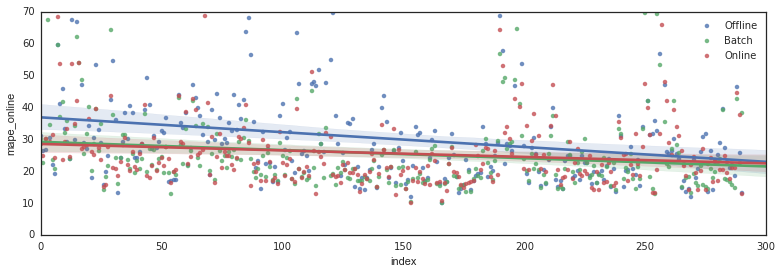

In [107]:
a=main_subset.groupby(main_subset.index.to_datetime().dayofyear, sort=False).apply(mape)

#tmp = main_subset.loc['2014-04-17 00:00:00':'2015-02-01 23:59:00']
#a=tmp.groupby(tmp.index.to_datetime().dayofyear, sort=False).apply(mape)

b = a[['mape_offline','mape_batch', 'mape_online']]

c = b[b > 0].reset_index()[['mape_offline','mape_batch', 'mape_online']]
c = c.fillna(0)
#c = b.reset_index()[['mape_offline','mape_batch']]
c['index'] = c.index

plt.figure(figsize=(13,4))
#sns.pairplot(c, size=5, aspect=.8, kind="reg");
g = sns.regplot(y="mape_offline", x="index", data=c, label='Offline');
g.set(xlim=(0,300), ylim=(0,70))
sns.regplot(y="mape_batch", x="index", data=c, label='Batch');
sns.regplot(y="mape_online", x="index", data=c, label='Online');

plt.legend(loc='upper right')
plt.show()

In [108]:
import scipy

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=g.get_lines()[0].get_xdata(),y=g.get_lines()[0].get_ydata())
print "Offline slope:", slope

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=g.get_lines()[1].get_xdata(),y=g.get_lines()[1].get_ydata())
print "Batch slope:", slope

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=g.get_lines()[2].get_xdata(),y=g.get_lines()[2].get_ydata())
print "Online slope:", slope

Offline slope: -0.0464784434115
Batch slope: -0.0256981767233
Online slope: -0.0202911373695


In [143]:
main_subset.to_csv('./data/predictions_rf_id14061721.csv')

## Future work

- more horizons
- more sensors
- online approach